In [8]:
import streamlit as st
import plotly.graph_objects as go
import utility
import pandas as pd 
import numpy as np
import os
from utility import *
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
YEARS = list(range(2018, 2025))

In [10]:
utility.retrieve_betting_data(YEARS) 

File already exists, skipping: betting_data/2018.xlsx
File already exists, skipping: betting_data/2019.xlsx
File already exists, skipping: betting_data/2020.xlsx
File already exists, skipping: betting_data/2021.xlsx
File already exists, skipping: betting_data/2022.xlsx
File already exists, skipping: betting_data/2023.xlsx
File already exists, skipping: betting_data/2024.xlsx


### Proposed Strategy
I want to see how value betting can be leveraged to gain a long-term edge over the bookmaker. We will explore different models that could help us evaluate what the odds truly are later. This is the basis of value betting and here’s a brief explanation of how it works:


##### How It Works

1. **Calculate True Probability**: Use data or models to estimate the actual likelihood of an event.  
   Example: If a tennis player has a 60% chance of winning, the **true odds** are:
   $$
   \text{True Odds} = \frac{1}{0.6} = 1.67
   $$

2. **Compare with Bookmaker Odds**: If the bookmaker offers odds of 2.00, the bet has value:
   $$
   \text{Value} = 0.6 \times 2.00 = 1.2
   $$

   Since the value is greater than 1, it’s a profitable bet.

##### How Do Odds Work?

Odds represent the likelihood of an event and determine how much you can win on a bet. They can be expressed as **decimal**, **fractional**, or **moneyline** odds.

##### Example:
- Decimal odds of **2.50** mean you win $2.50 for every $1 bet (including your stake).
- If you bet $10 on odds of 2.50, your total return is:
  $$
  \text{Return} = 10 \times 2.50 = 25
  $$
  Your profit is $15 ($25 - $10 stake).



### Evaluating bookmarker's success rate:

In [11]:
def evaluate_bookmaker_accuracy(df, bookmaker_prefix):
    odds_winner_col = bookmaker_prefix + 'W'
    odds_loser_col = bookmaker_prefix + 'L'
    mask_valid = (
        df[odds_winner_col].notnull() & 
        df[odds_loser_col].notnull() & 
        (df[odds_winner_col] > 0) & 
        (df[odds_loser_col] > 0)
    )
    valid_df = df[mask_valid].copy()
    valid_df["bookmaker_favorite_is_dataset_winner"] = (
        valid_df[odds_winner_col] < valid_df[odds_loser_col]
    )
    accuracy = valid_df["bookmaker_favorite_is_dataset_winner"].mean()
    return accuracy

df = pd.read_excel("betting_data/2018.xlsx")
bookmakers = ["B365", "EX", "LB", "PS"]
bookmakers_abbrev_to_full = {"B365": "Bet365", "EX": "Expekt", "LB": "Ladbrokes", "PS": "Pinnacle Sports"}
results = {}

for bm in bookmakers:
    acc = evaluate_bookmaker_accuracy(df, bm)
    results[bm] = acc
for bm in bookmakers:
    print(f"{bookmakers_abbrev_to_full[bm]}: {results[bm]:.2%}")

Bet365: 66.50%
Expekt: 67.61%
Ladbrokes: 65.59%
Pinnacle Sports: 67.94%


### Looking into naive betting Strategies:
1. Random betting
2. Bet with player with higher bookmaker's odds
3. Bet player with higher ranking

In [ ]:
data = load_data_for_years(list(range(2018, 2025)))

In [ ]:
def backtest_with_signal(dataset):
    dataset = dataset.copy()
    dataset["signal"] = dataset["signal"].shift(1)
    dataset["signal"].iloc[0] = 0
    dataset["signal"] = dataset["signal"].fillna(0)
    dataset["strategy_return"] = dataset["signal"] * dataset["return"]
    dataset["strategy_cum_return"] = (1 + dataset["strategy_return"]).cumprod()
    return dataset

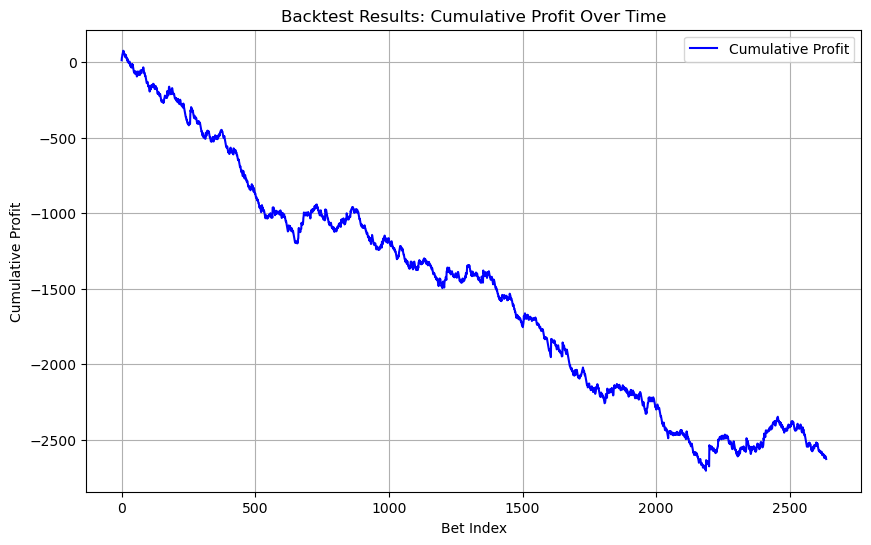

In [43]:
def backtest_with_signal(dataset, amount_per_bet=1):
    dataset["BetIsWin"] = (dataset["Signal"] == 1)
    dataset["Profit"] = np.where(
        dataset["BetIsWin"], 
        (dataset["B365W"] - 1) * amount_per_bet,
        -1 * amount_per_bet                           
    )
    dataset["Cumulative_Profit"] = dataset["Profit"].cumsum()
    return dataset


def plot_cumulative_profit(dataset):
    plt.figure(figsize=(10, 6))
    plt.plot(dataset["Cumulative_Profit"], label="Cumulative Profit", color="blue")
    plt.title("Backtest Results: Cumulative Profit Over Time")
    plt.xlabel("Bet Index")
    plt.ylabel("Cumulative Profit in $")
    plt.legend()
    plt.grid(True)
    plt.show()


data["Signal"] = np.random.choice([0, 1], size=len(data))

result = backtest_with_signal(data, amount_per_bet=10)

plot_cumulative_profit(result)


In [37]:
def backtest_favorite(dataset, amount_per_bet=1):
    """
    Backtest a strategy where you always bet on the side
    with the lower (favorite) odds.
    
    In the typical tennis dataset:
      - B365W = odds for the side that actually won
      - B365L = odds for the side that actually lost
    
    If B365W < B365L, then the winner was favored,
    so you 'win' this bet. Otherwise, you 'lose' the bet.
    """
    # Create a boolean column indicating if the side you bet on (the favorite) won:
    # In this dataset, the winning side is always the side with B365W.
    # So if the winning side had the lower odds, you "chose" that side and won.
    dataset["BetIsWin"] = dataset["B365W"] < dataset["B365L"]
    
    # Calculate profit:
    # If you "bet" on the side that actually won (favorite won),
    # Profit = (odds - 1) * stake.
    # Otherwise, you lose your stake => -1 * stake.
    dataset["Profit"] = np.where(
        dataset["BetIsWin"],
        (dataset["B365W"] - 1) * amount_per_bet,
        -1 * amount_per_bet
    )
    
    # Running total
    dataset["Cumulative_Profit"] = dataset["Profit"].cumsum()

    return dataset

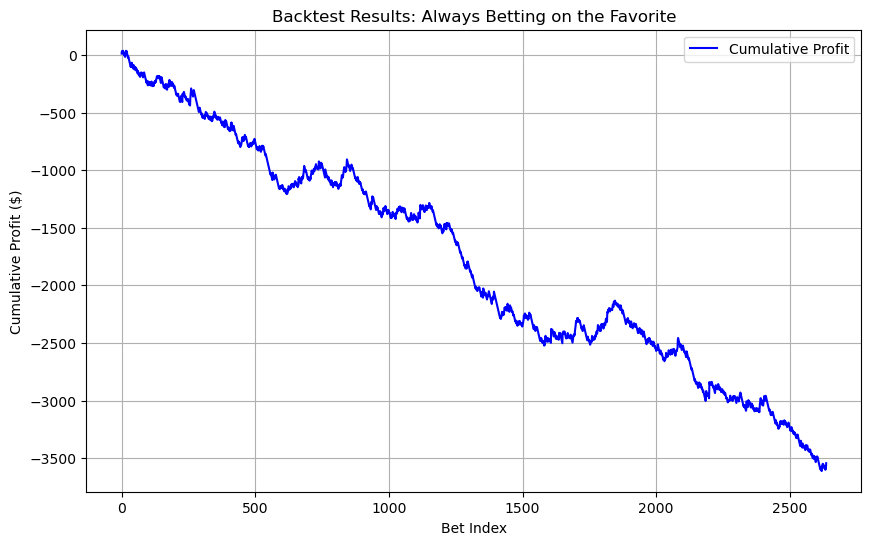

In [38]:
def plot_cumulative_profit(dataset, profit_col="Cumulative_Profit"):
    """
    Plot the cumulative profit column over bet index.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(dataset[profit_col], label="Cumulative Profit", color="blue")
    plt.title("Backtest Results: Always Betting on the Favorite")
    plt.xlabel("Bet Index")
    plt.ylabel("Cumulative Profit ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Example usage:
# -------------------------------
# 1. Load your dataset
data = pd.read_excel("betting_data/2018.xlsx")

# 2. Run the "favorite-based" backtest
result = backtest_favorite(data, amount_per_bet=10)

# 3. Plot the cumulative profit
plot_cumulative_profit(result)

In [36]:
result.head(100)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,LBL,PSW,PSL,MaxW,MaxL,AvgW,AvgL,BetIsWin,Profit,Cumulative_Profit
0,1,Brisbane,Brisbane International,2017-12-31,ATP250,Outdoor,Hard,1st Round,3,Dolgopolov O.,...,1.67,2.24,1.71,2.29,1.77,2.17,1.68,False,-10.0,-10.00
1,1,Brisbane,Brisbane International,2017-12-31,ATP250,Outdoor,Hard,1st Round,3,De Minaur A.,...,1.44,3.14,1.41,3.25,1.44,2.96,1.39,False,-10.0,-20.00
2,1,Brisbane,Brisbane International,2018-01-01,ATP250,Outdoor,Hard,1st Round,3,Harrison R.,...,2.20,1.66,2.35,1.75,2.35,1.67,2.17,True,6.1,-13.90
3,1,Brisbane,Brisbane International,2018-01-01,ATP250,Outdoor,Hard,1st Round,3,Ebden M.,...,1.57,2.38,1.64,2.52,1.65,2.37,1.58,False,-10.0,-23.90
4,1,Brisbane,Brisbane International,2018-01-01,ATP250,Outdoor,Hard,1st Round,3,Zverev M.,...,2.37,1.44,3.00,1.57,3.00,1.44,2.73,True,4.0,-19.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,Auckland,ASB Classic,2018-01-09,ATP250,Outdoor,Hard,1st Round,3,Haase R.,...,3.25,1.40,3.18,1.40,3.26,1.37,3.08,True,3.6,-59.65
96,4,Auckland,ASB Classic,2018-01-09,ATP250,Outdoor,Hard,1st Round,3,Chung H.,...,4.00,1.25,4.37,1.28,4.55,1.23,4.09,True,2.2,-57.45
97,4,Auckland,ASB Classic,2018-01-09,ATP250,Outdoor,Hard,2nd Round,3,Bautista Agut R.,...,3.50,1.30,3.96,1.35,3.96,1.29,3.57,True,2.8,-54.65
98,4,Auckland,ASB Classic,2018-01-10,ATP250,Outdoor,Hard,2nd Round,3,Haase R.,...,2.20,1.74,2.22,1.84,2.30,1.75,2.07,True,7.2,-47.45
